### The Data

In [1]:
import pandas as pd

In [2]:
# https://www.kaggle.com/joshmcadams/oranges-vs-grapefruit
df = pd.read_csv('data/citrus.csv')

In [3]:
df.sample(5)

,diameter,weight,hexcode,fruit
1740,8.76,156.75,#97660F,orange
356,14.20,240.37,#8C4017,grapefruit
5770,8.17,148.16,#A34E05,orange
2007,8.30,149.79,#955004,orange
51,11.29,194.99,#9E5018,grapefruit


In [4]:
df.shape

(10000, 4)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
diameter,10000.0,9.975685,1.947844,2.96,8.46,9.980,11.4800,16.45
weight,10000.0,175.050792,29.212119,86.76,152.22,174.985,197.7225,261.51


### Select + Split

In [6]:
target = 'fruit'
y = df[target]
X = df.drop(target, axis=1)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
X_train.head(5)

,diameter,weight,hexcode
4901,11.85,203.54,#9D4B18
4375,7.87,143.57,#9F5502
6698,8.19,142.93,#953F10
9805,7.12,133.20,#AF6402
1101,7.61,139.68,#9B500D


### Dealing with hexcodes

In [10]:
from matplotlib import pyplot as plt

In [11]:
def plot_color(color):
    plt.scatter([1], [1], c=color, s=10000)
    plt.xticks([])
    plt.yticks([])
    plt.show()

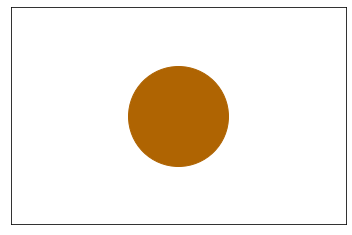

In [12]:
plot_color('#AF6402')

In [13]:
def hex2rgb(hex):
    hex = hex.replace('#', '')
    return int(hex[0:2],16), int(hex[2:4],16), int(hex[4:6],16)

In [14]:
hex2rgb('#AF6402')

(175, 100, 2)

In [15]:
df['hexcode'].apply(hex2rgb)

0        (147, 74, 7)
1       (152, 61, 25)
2       (159, 87, 18)
3       (151, 62, 14)
4        (152, 82, 9)
            ...      
9995     (145, 70, 6)
9996     (127, 98, 2)
9997    (147, 69, 17)
9998    (159, 100, 2)
9999    (149, 71, 29)
Name: hexcode, Length: 10000, dtype: object

In [16]:
X_train['hexcode'].apply(hex2rgb).apply(pd.Series)

,0,1,2
4901,157,75,24
4375,159,85,2
6698,149,63,16
9805,175,100,2
1101,155,80,13
...,...,...,...
5734,157,84,24
5191,133,83,12
5390,150,72,2
860,143,80,31


In [17]:
class HexTransformer:
    
    @staticmethod
    def hex2rgb(hex):
        hex = hex.replace('#', '')
        return int(hex[0:2],16), int(hex[2:4],16), int(hex[4:6],16)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(self.hex2rgb).apply(pd.Series)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [18]:
ht = HexTransformer()
ht.fit_transform(X_train['hexcode'])

,0,1,2
4901,157,75,24
4375,159,85,2
6698,149,63,16
9805,175,100,2
1101,155,80,13
...,...,...,...
5734,157,84,24
5191,133,83,12
5390,150,72,2
860,143,80,31


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [20]:
X_train.head(5)

,diameter,weight,hexcode
4901,11.85,203.54,#9D4B18
4375,7.87,143.57,#9F5502
6698,8.19,142.93,#953F10
9805,7.12,133.20,#AF6402
1101,7.61,139.68,#9B500D


In [21]:
mapper = DataFrameMapper([
    ('hexcode', HexTransformer(), {'input_df': True}),
    (['diameter'], StandardScaler()), 
    (['weight'], StandardScaler()),
], df_out=True)

In [22]:
Z_train = mapper.fit_transform(X_train)

In [23]:
Z_train.head()

,hexcode_0,hexcode_1,hexcode_2,diameter,weight
4901,157,75,24,0.950395,0.962671
4375,159,85,2,-1.086118,-1.082380
6698,149,63,16,-0.922379,-1.104205
9805,175,100,2,-1.469884,-1.436010
1101,155,80,13,-1.219157,-1.215034


In [24]:
Z_test = mapper.transform(X_test)

### The Model

In [25]:
from sklearn.svm import SVC

In [26]:
model = SVC()

In [27]:
model.fit(Z_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
model.score(Z_train, y_train)

0.8797333333333334

In [29]:
model.score(Z_test, y_test)

0.8712

In [30]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(Z_train, y_train)

dummy.score(Z_train, y_train), (dummy.score(Z_test, y_test))

/Users/max/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


(0.496, 0.4968)

### Pipeline

In [31]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(mapper, model)

In [32]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8712

In [33]:
X_train.sample().to_dict(orient='list')

{'diameter': [11.39], 'weight': [196.7], 'hexcode': ['#AE4819']}

In [34]:
new = pd.DataFrame({
    'diameter': [12.85], 
    'weight': [128.68], 
    'hexcode': ['#A55602']
})

In [35]:
pipe.predict(new)

array(['orange'], dtype=object)

#### Pickle 

In [36]:
import pickle

In [37]:
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

del pipe

In [38]:
with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

In [39]:
pipe.predict(new)[0]

'orange'